In [1]:
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA, SparsePCA, KernelPCA, NMF
import matplotlib.pyplot as plt
from  sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
import tensorflow as tf
from sklearn_wrappers import spca_exp_faces, kernel_exp, autoencoder_exp, nmf_exp_faces
import kernel_pca as kpca

In [2]:
# Takes 6 minutes to load the data if this is your first time
lfw_people = fetch_lfw_people(min_faces_per_person=100)
n_samples, h, w = lfw_people.images.shape
X = lfw_people.data
n_features = X.shape[1]
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)
k=2 # no. of components

In [3]:
best_spca_alpha, best_spca_alpha_err, best_eigenfaces_spca = spca_exp_faces(X_train, X_test, k, h, w)

alpha= 0.001 err= 0.016511442
alpha= 0.002 err= 0.016511476
alpha= 0.005 err= 0.016511576
alpha= 0.01 err= 0.016511746
alpha= 0.02 err= 0.016512128


Best SPCA:
- alpha: 0.001
- err: 0.016511442


In [4]:
best_kernel, best_kernel_err = kernel_exp(X_train, X_test, k)

Kernel PCA ( Linear kernel ) MSE reconstruction loss: 0.2068138
- New best kernel
Kernel PCA ( RBF kernel, $\gamma=0.04$ ) MSE reconstruction loss: 0.021248043
- New best kernel
Kernel PCA ( Sigmoid kernel, $\gamma=10^{-3}, r=1$ ) MSE reconstruction loss: 0.022155931


Best MSE reconstruction error: 0.021248043
- Kernel: RBF kernel, $\gamma=0.04$


In [5]:
# Own kpca implementation
X_recon_kernel_pca, X_recon_kernel_pca_err = kpca.kernel_PCA(X_train, X_test, n_components=k, kernel='rbf', gamma=0.0433, mode='recon', alpha=1.0)
X_recon_kernel_pca_err

0.021248043295164745

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2914)]            0         
                                                                 
 encoding (Dense)            (None, 2)                 5830      
                                                                 
 decoding (Dense)            (None, 2914)              8742      
                                                                 
Total params: 14,572
Trainable params: 14,572
Non-trainable params: 0
_________________________________________________________________


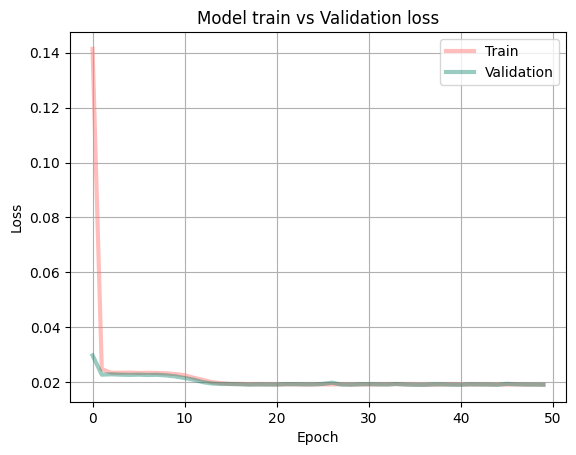

Training loss: 0.019098732620477676
Validation loss: 0.019065890461206436
MSE on training data: 0.01482135786524777
MSE on test data: 0.015066456861450568


In [6]:
_,best_autoencoder_err = autoencoder_exp(X_train, X_test, k)
# After I added activation function, the MSE doubled

In [7]:
nmf_err_train, nmf_err_test, eigenfaces_nmf = nmf_exp_faces(X_train, X_test, k, h, w)



Best NMF:
Basis vectors:
 [[0.22296092 0.24771835 0.2720831  ... 0.87062055 0.8343242  0.7740709 ]
 [0.49703145 0.49709144 0.5196843  ... 0.02404256 0.         0.        ]]
Coefficients:
 [[0.4503498  0.6300737 ]
 [0.61438096 0.40709376]
 [0.54352885 0.52852875]
 ...
 [0.5054304  0.4649096 ]
 [0.65527165 0.31647062]
 [0.4105089  0.49735072]]


Best MSE reconstruction error on train data: 0.014722685
Best MSE reconstruction error on test data: 0.014913997


c:\Users\Jasmine\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [8]:
def plot_gallery(images, titles, h, w, n_row=1, n_col=k):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(k):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

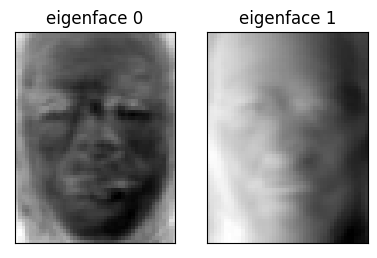

In [9]:
eigenface_titles_spca = [f"eigenface {i}" for i in range(best_eigenfaces_spca.shape[0])]
plot_gallery(best_eigenfaces_spca, eigenface_titles_spca, h, w)

plt.show()

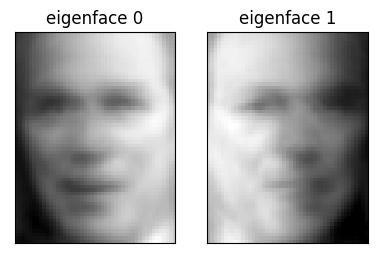

In [10]:
eigenface_titles_nmf = [f"eigenface {i}" for i in range(eigenfaces_nmf.shape[0])]
plot_gallery(eigenfaces_nmf, eigenface_titles_nmf, h, w)

plt.show()
